# Import modules

In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Create the hybrid dataset containing categories of interest

## The below block is the only variable assignment (only block user should edit)

In [2]:
# Introduce variables
# Note that this script expects raw data to be in adata.raw.X

# Introduce the path you'd like to save data to (you must create a 'figures' folder within this)
save_data_name = "/Users/b8058304/Documents/PhD_work/Coding/useful_scripts/lr_test/"

# Name of first object
data1 = "_YS_train"
# Provide path to obj1 // landscape/training data
Object1 = "/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Name of second object
data2 = "_YS_predicted"
# Provide path to obj2 // prediction/projection data
Object2 = "/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Misc Options
subsample_train = False #samples the training data to the smallest fraction (highly dependent on resolution of input categorical)
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = "orig.ident" # Will accept any batch categorical
train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' #"./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

# LR options
penalty='l2' 
sparcity=0.2 

# Combine and pre-process data to match correlations across PCA

In [3]:
# Check if filepaths are good
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    adata2 =  sc.read(Object2)
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and match data')
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

#optional subsampling of training data to 
if(subsample_train == True):
    data = adata.obs
    data = data.sample(frac=1).groupby('corr_concat').head(min(adata.obs.groupby(cat1).size()))
    keep = data.index
    adata = adata[adata.obs.index.isin(keep)]

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=True, max_value=None, copy=False)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"
    
#Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

#batch correction options
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm,n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

adata file paths detetcted, proceeding to load
option detected to use raw data, proceeding to check if raw exists and match data
no raw data detected in adata! proceeding to create raw partition from adata.X
no raw data detected in adata! proceeding to create raw partition from adata.X
keep gene list =  32084 adata1 gene length =  32084 adata2 gene length =  32084


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Or pass `index_unique!=None` to `.concatenate`.


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Custom gene list option is not selected or path is not readbale, proceeding with no variable removal
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
Commencing harmony


2020-11-06 10:32:01,853 - harmonypy - INFO - Iteration 1 of 10
2020-11-06 10:32:06,055 - harmonypy - INFO - Iteration 2 of 10
2020-11-06 10:32:10,535 - harmonypy - INFO - Iteration 3 of 10
2020-11-06 10:32:15,030 - harmonypy - INFO - Iteration 4 of 10
2020-11-06 10:32:17,869 - harmonypy - INFO - Iteration 5 of 10
2020-11-06 10:32:22,567 - harmonypy - INFO - Iteration 6 of 10
2020-11-06 10:32:25,819 - harmonypy - INFO - Iteration 7 of 10
2020-11-06 10:32:30,488 - harmonypy - INFO - Iteration 8 of 10
2020-11-06 10:32:34,562 - harmonypy - INFO - Iteration 9 of 10
2020-11-06 10:32:37,594 - harmonypy - INFO - Iteration 10 of 10
2020-11-06 10:32:40,674 - harmonypy - INFO - Converged after 10 iterations
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics f

    finished (0:00:08)
adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!


In [4]:
# This function require compute power, will take a while 

def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity)

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.X,
        # Define prediction parameters
        predict_x = train_x
        train_x = train_x[subset_train, :]
        predict_x = train_x
        predict_x = predict_x[subset_predict]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    #Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

#Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

## Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

# Now the LR magic happens...

## Logistic Regression pre-face

In [5]:
# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"

# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

LR_compare(adata, train_x, train_label, subset_predict, subset_train, sparcity=sparcity, col_name='predicted')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

# Plotting purposes - Subset data to only contain prediction data with new predicted labels

In [6]:
# Make adata the predicted data with projected annotations in adata.obs["predicted"]. "corr_concat" contains old 
# cell.labels and dataset name combined 
common_cat = "corr_concat"
adata_concat = adata[:]
adata = adata[adata.obs["predicted"].isin(group1)]
adata = adata[adata.obs["corr_concat"].isin(group2)]

In [7]:
# The results, are displayed in a python notebook or rendered as a html
crs_tbl = cross_table(adata, x = 'predicted', y = common_cat, highlight = True)
crs_tbl

corr_concat,DC progenitor_YS_predicted,Early mast cell_YS_predicted,Endothelium_YS_predicted,Erythroid AB_YS_predicted,Erythroid EZ_YS_predicted,Erythroid M_YS_predicted,ILC precursor_YS_predicted,Lymphoid progenitor_YS_predicted,MEMP_YS_predicted,Monocyte_YS_predicted,Myeloid progenitor_YS_predicted,NK early_YS_predicted,yolk sac Macrophage II_YS_predicted,yolk sac Macrophage I_YS_predicted,yolk sac progenitor/MPP_YS_predicted
predicted,,,,,,,,,,,,,,,
DC progenitor_YS_train,47,0,0,0,0,0,0,8,1,0,0,0,3,0,1
Early mast cell_YS_train,0,130,0,0,0,0,0,0,4,0,0,0,0,0,0
Endothelium_YS_train,0,0,160,0,0,0,0,0,0,0,0,0,0,0,0
Erythroid AB_YS_train,0,0,0,741,92,0,0,0,2,0,0,0,0,0,0
Erythroid EZ_YS_train,0,0,0,151,1068,13,0,0,15,0,0,0,0,0,0
Erythroid M_YS_train,0,0,0,0,3,257,0,0,1,0,0,0,1,1,0
ILC precursor_YS_train,0,0,0,0,0,0,25,1,0,0,0,0,0,0,0
Lymphoid progenitor_YS_train,10,0,0,0,0,0,0,150,0,0,0,5,20,2,3
MEMP_YS_train,0,3,0,0,4,5,0,0,95,0,0,0,1,0,2


# Plot LR as a highlighted table by percentage

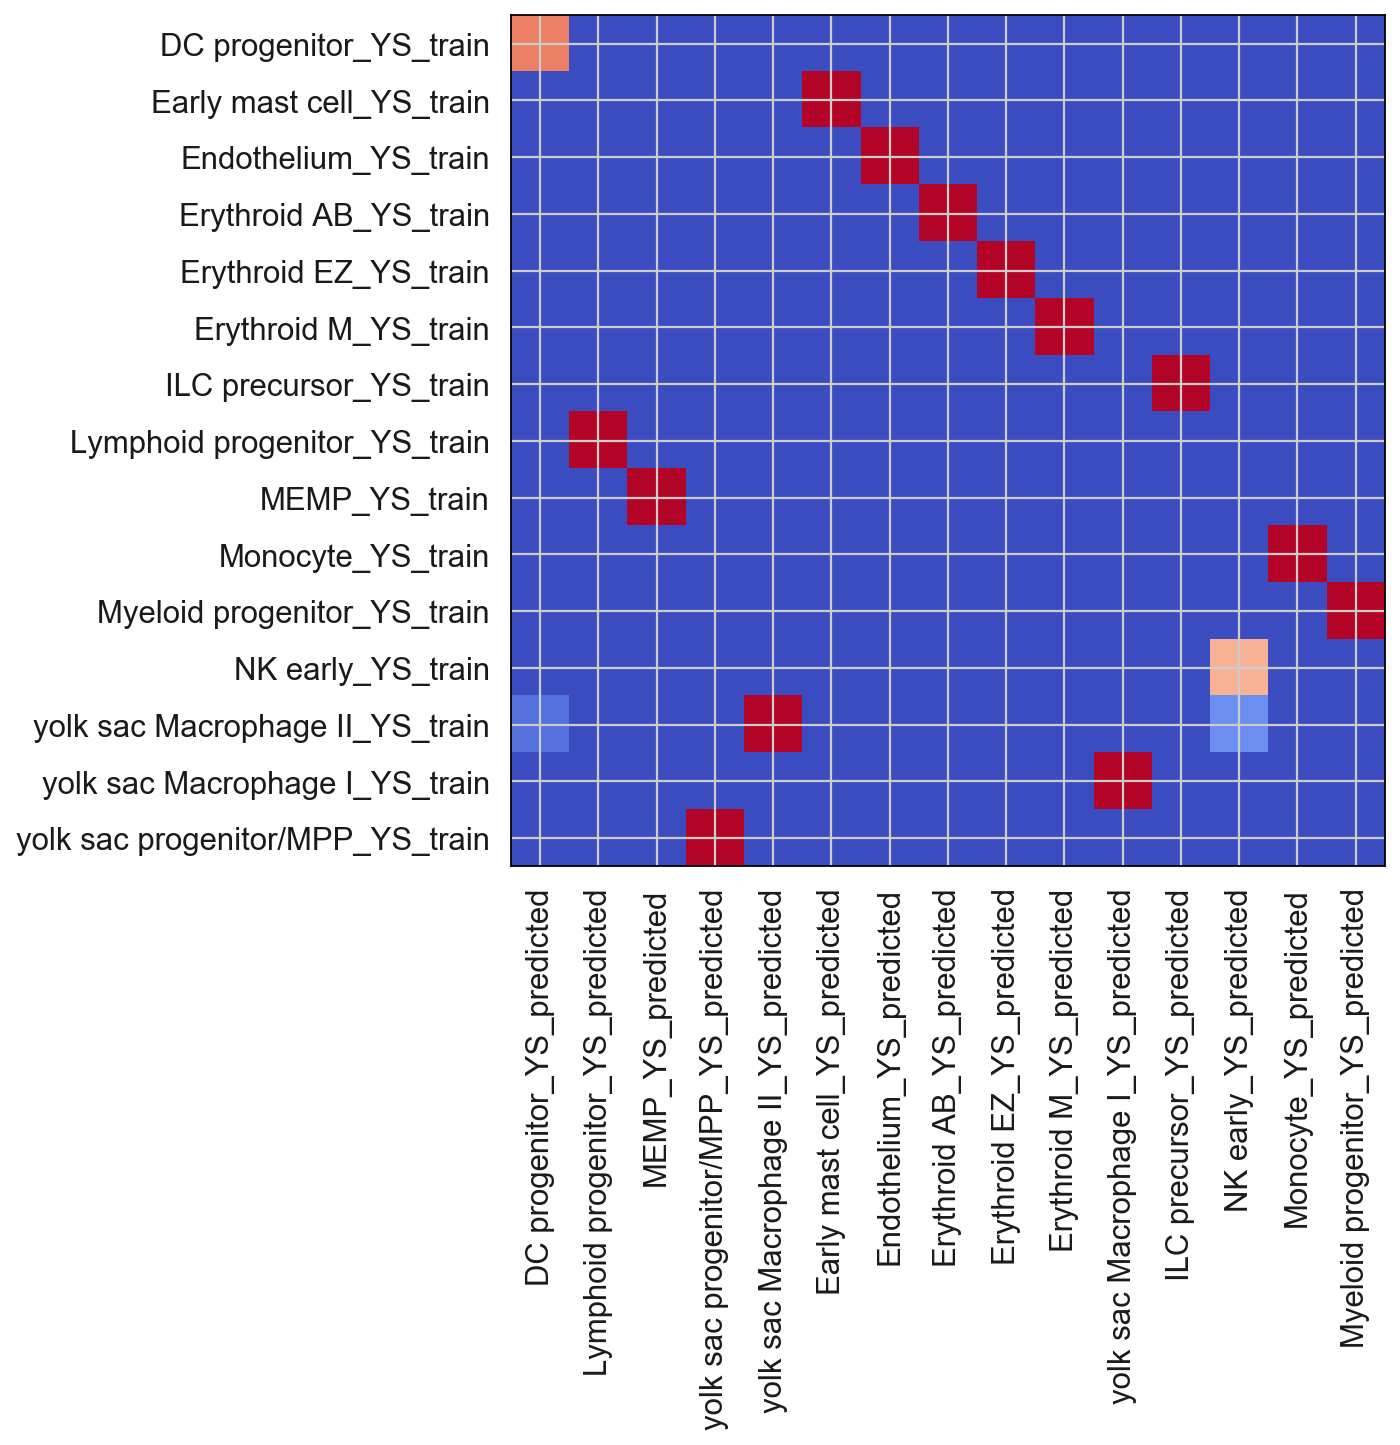

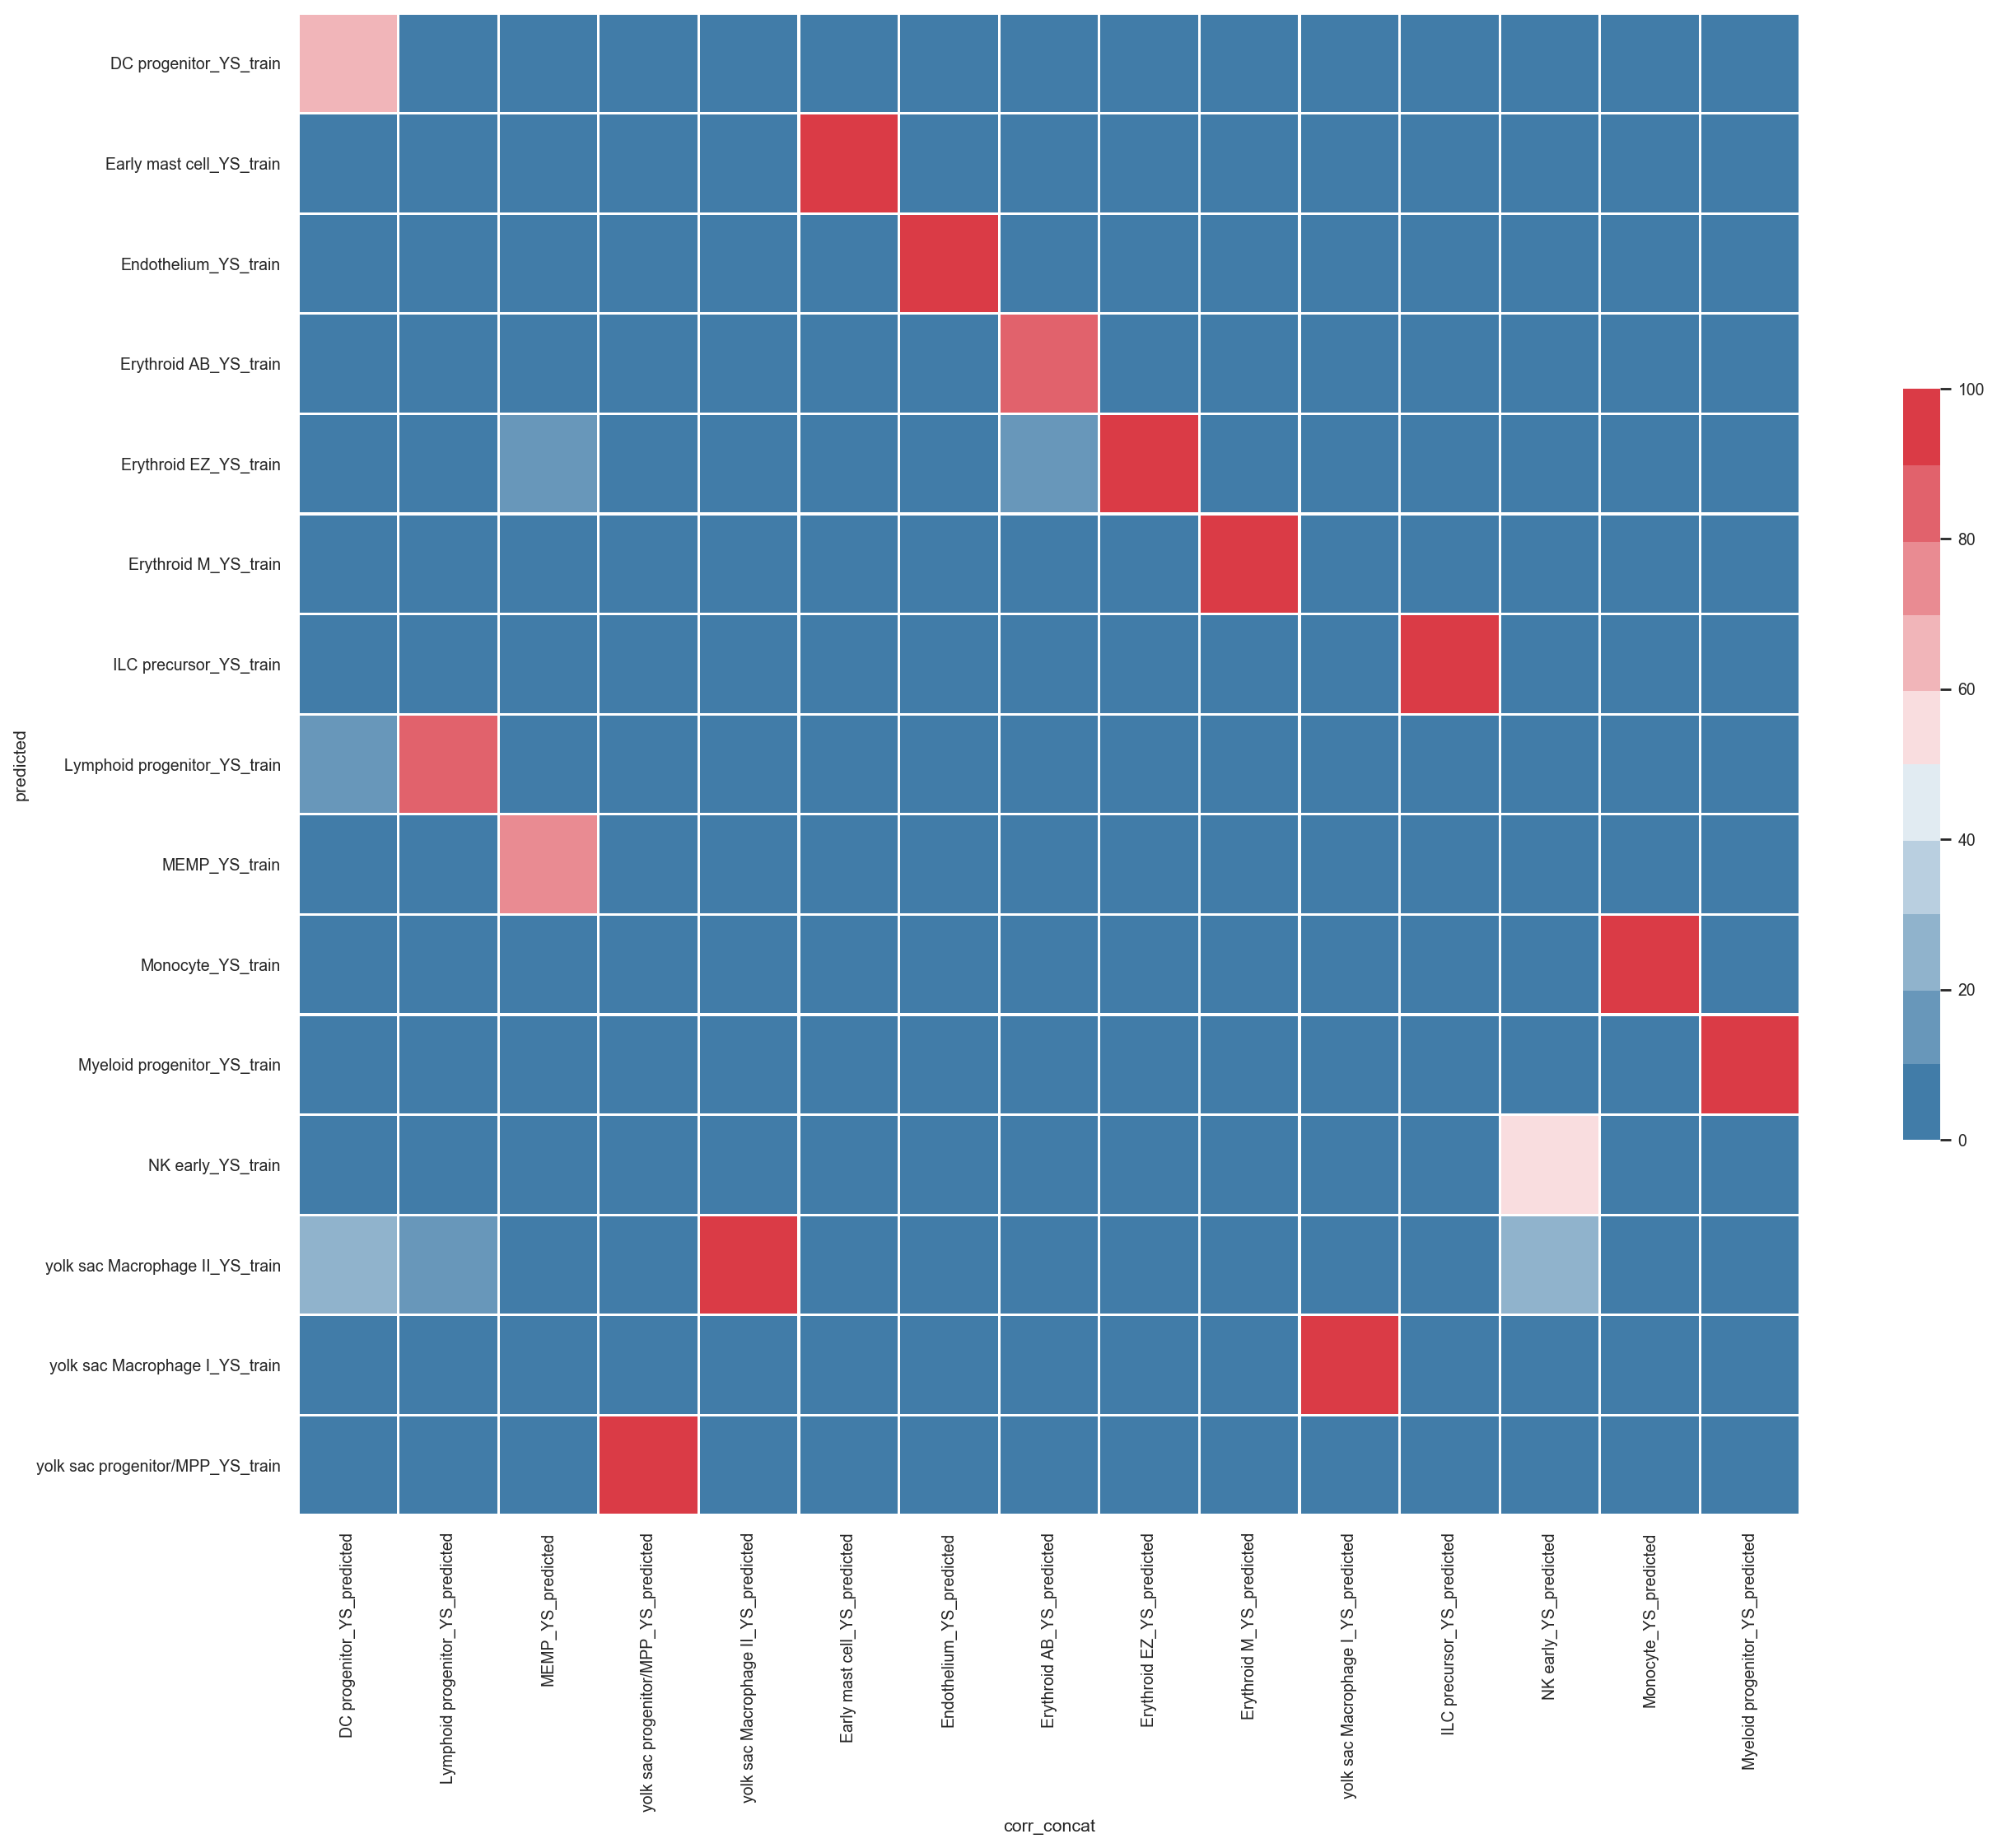

In [8]:
x = 'predicted'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
    
#Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)

plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.savefig("figures/LR_predictions.pdf")
crs_tbl.to_csv("figures/pre-freq_LR_predictions_supp_table.csv")

# Output Proportions

In [9]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv("figures/pre-freq_predicted_prop.csv")
prop

predicted
DC progenitor_YS_train              0.017513
Early mast cell_YS_train            0.007005
Endothelium_YS_train                0.000000
Erythroid AB_YS_train               0.003503
Erythroid EZ_YS_train               0.026270
Erythroid M_YS_train                0.001751
ILC precursor_YS_train              0.001751
Lymphoid progenitor_YS_train        0.267951
MEMP_YS_train                       0.169877
Monocyte_YS_train                   0.001751
Myeloid progenitor_YS_train         0.103327
NK early_YS_train                   0.005254
yolk sac Macrophage II_YS_train     0.036778
yolk sac Macrophage I_YS_train      0.005254
yolk sac progenitor/MPP_YS_train    0.352014
Name: percentage, dtype: float64

# Redistribute the predicted values by frequency of grouping (Additive assignment)

In [10]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

Trying to set attribute `.obs` of view, copying.


running Leiden clustering
    finished (0:00:01)


In [11]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [12]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Output Freq Redistributed proportions

In [13]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv("figures/post-freq_predicted_leiden_consensus_prop.csv")

In [14]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

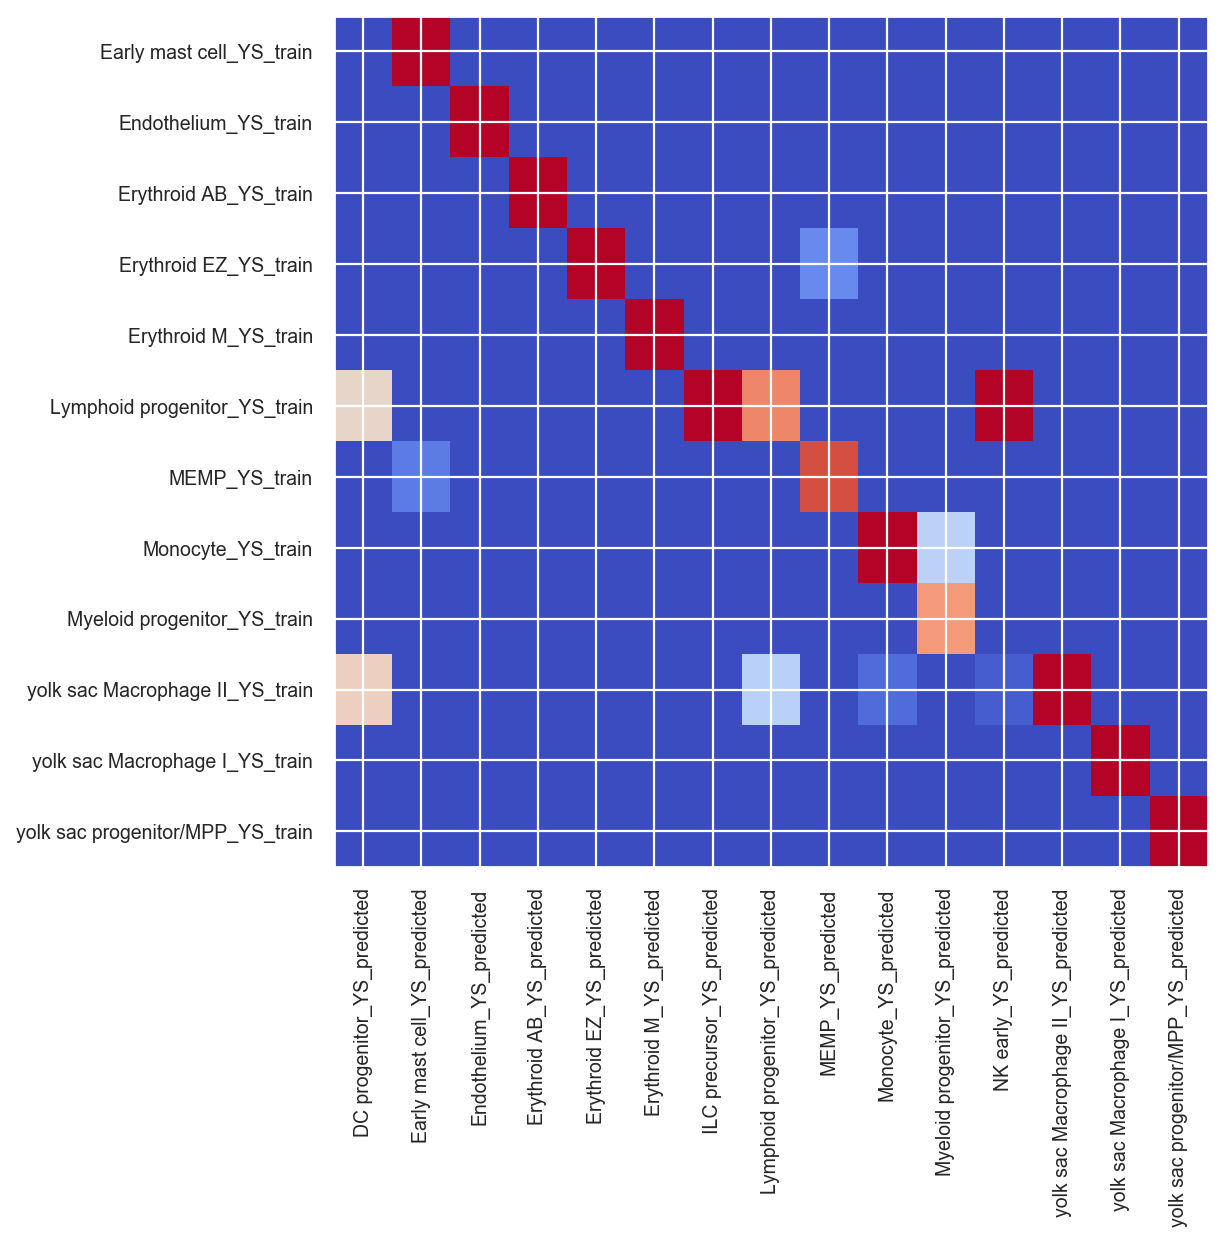

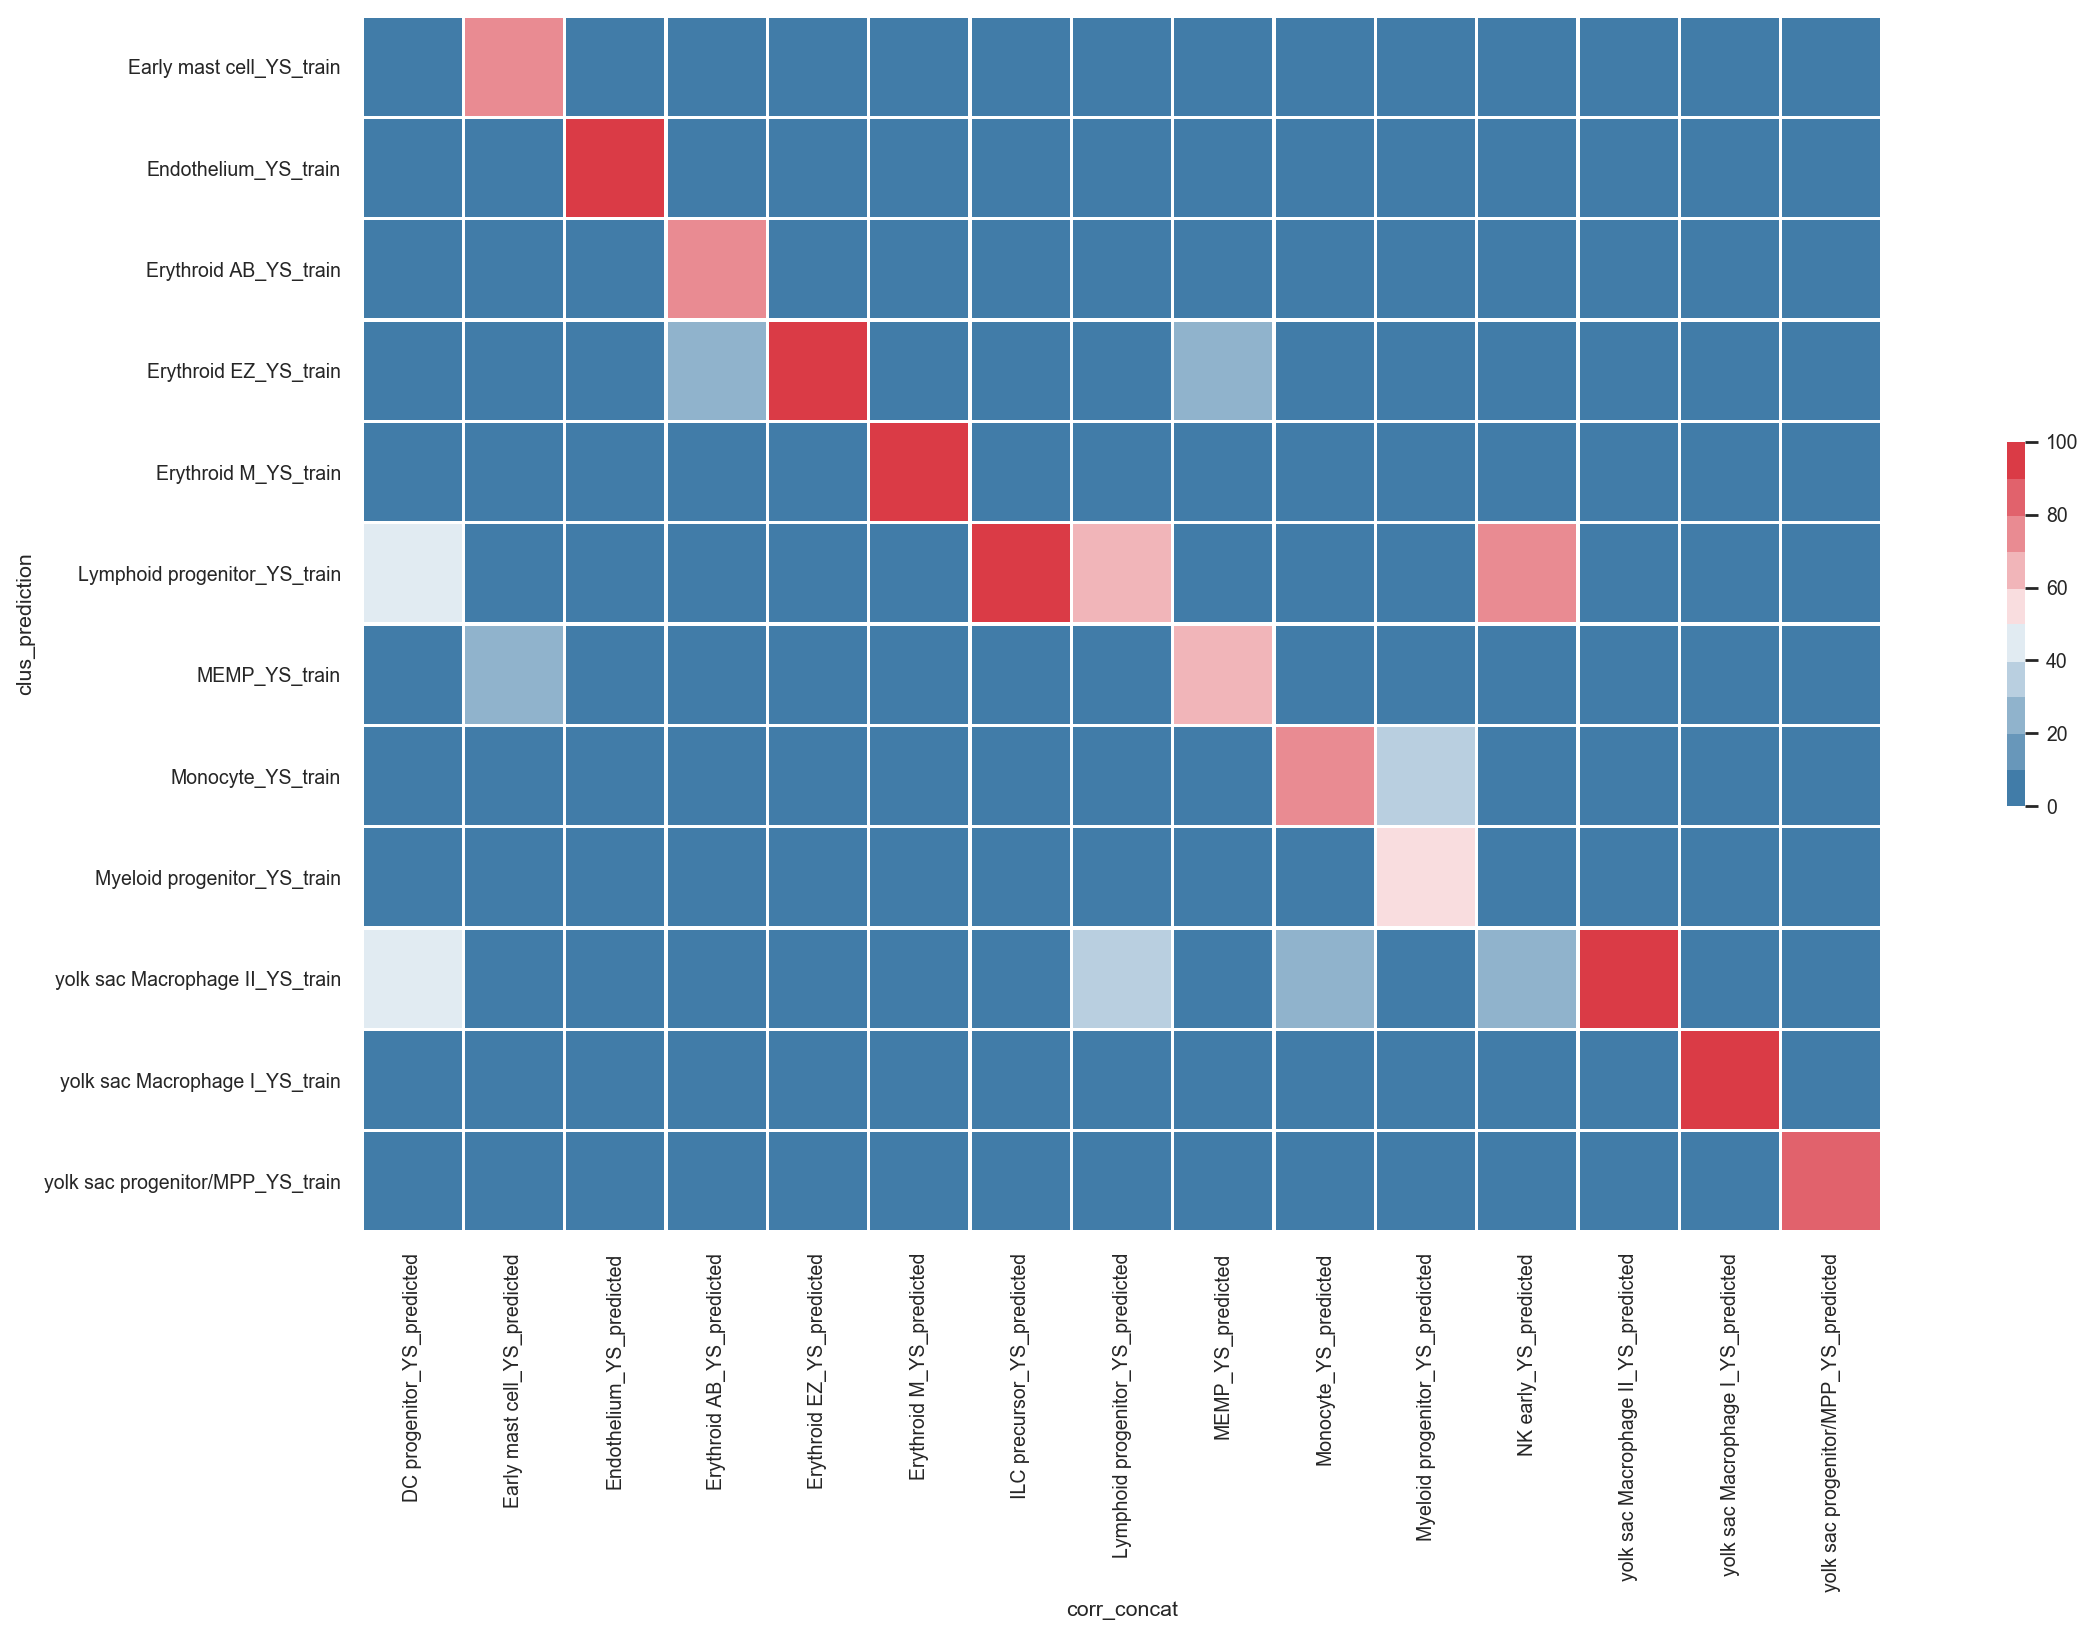

In [15]:
x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.savefig("figures/LR_predictions_consensus.pdf")
crs_tbl.to_csv("figures/post-freq_LR_predictions_consensus_supp_table.csv")

# Output Proportions

In [16]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv("figures/post-freq_predicted_prop_consensus.csv")
prop

predicted
DC progenitor_YS_train              0.017513
Early mast cell_YS_train            0.007005
Endothelium_YS_train                0.000000
Erythroid AB_YS_train               0.003503
Erythroid EZ_YS_train               0.026270
Erythroid M_YS_train                0.001751
ILC precursor_YS_train              0.001751
Lymphoid progenitor_YS_train        0.267951
MEMP_YS_train                       0.169877
Monocyte_YS_train                   0.001751
Myeloid progenitor_YS_train         0.103327
NK early_YS_train                   0.005254
yolk sac Macrophage II_YS_train     0.036778
yolk sac Macrophage I_YS_train      0.005254
yolk sac progenitor/MPP_YS_train    0.352014
Name: percentage, dtype: float64